In [0]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm

import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

from segnet import *
from dataset_class import *
# from apply import *

In [0]:
print(torch.__version__)

1.1.0


In [0]:
dataset = MyDataset('dataset/img/', 'dataset/masks_machine/', 'all')

In [0]:
len(dataset)

263

In [0]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [0]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=32)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=32)

In [0]:
dataset[0][1].type()

'torch.LongTensor'

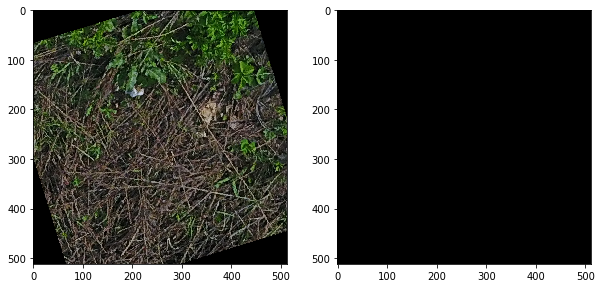

In [0]:
plt.figure(figsize=(10, 5))

sample = dataset[np.random.randint(len(dataset))]

plt.subplot(1, 2, 1)
plt.imshow(sample[0].permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(sample[1], 'gray')

In [0]:
sample[1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [0]:
sample[1].sum()

tensor(254023)

In [0]:
dataset[10][1].sum()

tensor(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


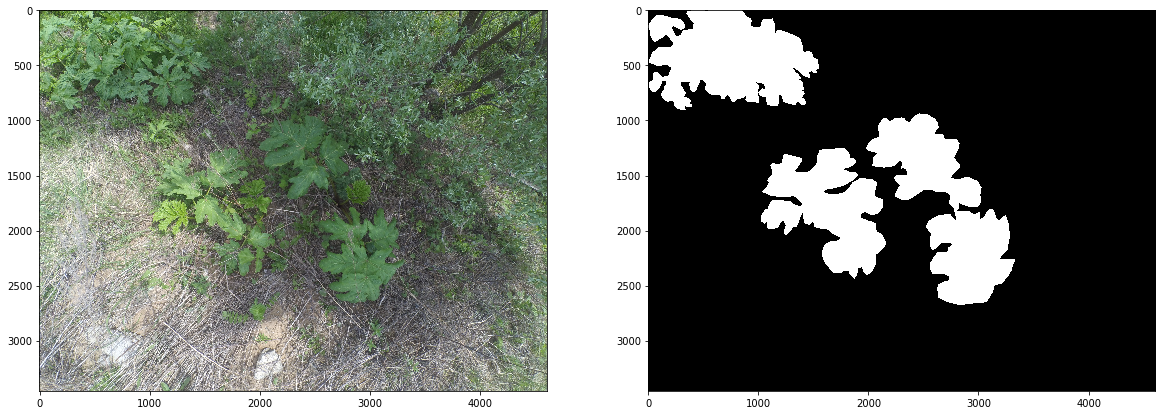

In [0]:
plt.figure(figsize=(20,16))
plt.subplot(1,2,1)
im = sp.misc.imread('NBST/img/0065.jpg')
plt.imshow(im)
plt.subplot(1,2,2)
mask = np.array(sp.misc.imread('NBST/masks_machine/0065.png'))[:,:,0]
plt.imshow(mask, 'gray')

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
model = segnet(n_classes=2, in_channels=3, is_unpooling=True).to(device)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

In [0]:
torch.cuda.device_count()

4

In [0]:
optim = torch.optim.Adam(model.parameters())
epochs = 1500

In [0]:
loss_layer = nn.NLLLoss()

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [0]:
loss_history = []
model.train(True)
for epoch in range(epochs):
    losses = []
    model.train(True)
    for i_train, (X, y) in tqdm(enumerate(train_loader)):
        X = X.to(device)  # [N, 3, H, W]
        y = y.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_layer(F.log_softmax(prediction, dim=1), y)
        #loss = F.cross_entropy(prediction, y)
        losses.append(loss.cpu().data)

        optim.zero_grad()
        loss.backward()
        optim.step()
    
#     iou = []
#     model.train(False)
#     for i_batch, (X, y) in tqdm(enumerate(val_loader)):
#         X = X.to(device)  # [N, 3, H, W]
#         y = y.to(device)  # [N, H, W] with class indices (0, 1)
#         preds_class = apply_model_to_full_image(model, y, overlap=0.05, batch_size=32,device='cuda')
#         # prediction = model.forward(X)  # [N, 2, H, W]
#         # preds_class = torch.max(prediction, dim=1)[1]
#         iou.append(calc_iou(preds_class.cpu().numpy(), y.cpu().numpy()))
#    
#    print('epoch: {}, loss:{:.4f}, val iou:{:.4f}'.format(epoch + 1, np.mean(losses), np.mean(iou)))
    print('epoch: {}, loss:{:.4f}'.format(epoch + 1, np.mean(losses)))
    loss_history.append(np.mean(losses))

14it [00:30,  1.42it/s]

epoch: 1, loss:0.6662



14it [00:18,  1.83it/s]

epoch: 2, loss:0.5946



14it [00:18,  1.77it/s]

epoch: 3, loss:0.5629



14it [00:19,  1.72it/s]

epoch: 4, loss:0.5617



14it [00:18,  1.74it/s]

epoch: 5, loss:0.5479



14it [00:18,  1.75it/s]

epoch: 10, loss:0.5293



14it [00:17,  1.76it/s]

epoch: 11, loss:0.5174



14it [00:18,  1.74it/s]

epoch: 12, loss:0.5082



14it [00:17,  1.76it/s]

epoch: 13, loss:0.5059



14it [00:19,  1.70it/s]

epoch: 14, loss:0.5001



14it [00:18,  1.72it/s]

epoch: 19, loss:0.4967



14it [00:18,  1.72it/s]

epoch: 20, loss:0.4798



14it [00:18,  1.74it/s]

epoch: 21, loss:0.4751



14it [00:17,  1.74it/s]

epoch: 22, loss:0.4790



14it [00:18,  1.73it/s]

epoch: 23, loss:0.4776



14it [00:18,  1.74it/s]

epoch: 24, loss:0.4695



14it [00:17,  1.76it/s]

epoch: 25, loss:0.4603



14it [00:17,  1.71it/s]

epoch: 26, loss:0.4564



14it [00:18,  1.72it/s]

epoch: 27, loss:0.4734



14it [00:18,  1.73it/s]

epoch: 28, loss:0.4569



14it [00:18,  1.74it/s]

epoch: 29, loss:0.4504



14it [00:18,  1.73it/s]

epoch: 30, loss:0.4484



14it [00:19,  1.69it/s]

epoch: 31, loss:0.4382



14it [00:18,  1.72it/s]

epoch: 32, loss:0.4562



14it [00:18,  1.73it/s]

epoch: 33, loss:0.4366



14it [00:18,  1.73it/s]

epoch: 34, loss:0.4598



14it [00:17,  1.73it/s]

epoch: 35, loss:0.4372



14it [00:17,  1.76it/s]

epoch: 36, loss:0.4186



14it [00:17,  1.76it/s]

epoch: 37, loss:0.4231



14it [00:18,  1.77it/s]

epoch: 38, loss:0.4307



14it [00:18,  1.69it/s]

epoch: 39, loss:0.4203



14it [00:18,  1.73it/s]

epoch: 40, loss:0.4208



14it [00:18,  1.73it/s]

epoch: 41, loss:0.4218



14it [00:18,  1.74it/s]

epoch: 42, loss:0.4112



14it [00:18,  1.70it/s]

epoch: 43, loss:0.4329



14it [00:17,  1.73it/s]

epoch: 44, loss:0.4169



14it [00:18,  1.81it/s]

epoch: 45, loss:0.4221



14it [00:18,  1.74it/s]

epoch: 46, loss:0.4133



14it [00:17,  1.79it/s]

epoch: 47, loss:0.4220



14it [00:19,  1.70it/s]

epoch: 48, loss:0.4214



14it [00:18,  1.71it/s]

epoch: 54, loss:0.3915



14it [00:19,  1.71it/s]

epoch: 55, loss:0.3845



14it [00:17,  1.76it/s]

epoch: 56, loss:0.3879



14it [00:18,  1.72it/s]

epoch: 57, loss:0.3732



14it [00:18,  1.72it/s]

epoch: 58, loss:0.3714



14it [00:18,  1.71it/s]

epoch: 59, loss:0.3901



14it [00:18,  1.72it/s]

epoch: 64, loss:0.3890



14it [00:17,  1.76it/s]

epoch: 65, loss:0.3747



14it [00:18,  1.79it/s]

epoch: 66, loss:0.3773



14it [00:18,  1.71it/s]

epoch: 67, loss:0.3797



14it [00:18,  1.71it/s]

epoch: 68, loss:0.3582



14it [00:18,  1.74it/s]

epoch: 69, loss:0.3615



14it [00:18,  1.77it/s]

epoch: 70, loss:0.3687



14it [00:18,  1.73it/s]

epoch: 71, loss:0.3699



14it [00:18,  1.73it/s]

epoch: 72, loss:0.3481



14it [00:17,  1.74it/s]

epoch: 73, loss:0.3717



14it [00:17,  1.76it/s]

epoch: 74, loss:0.3853



14it [00:18,  1.70it/s]

epoch: 75, loss:0.3560



14it [00:19,  1.69it/s]

epoch: 76, loss:0.3264



14it [00:18,  1.72it/s]

epoch: 77, loss:0.3806



14it [00:18,  1.70it/s]

epoch: 78, loss:0.3611



14it [00:18,  1.75it/s]

epoch: 79, loss:0.3480



14it [00:19,  1.76it/s]

epoch: 80, loss:0.3564



14it [00:18,  1.73it/s]

epoch: 81, loss:0.3451



14it [00:18,  1.73it/s]

epoch: 82, loss:0.3282



14it [00:17,  1.75it/s]

epoch: 83, loss:0.3542



14it [00:18,  1.72it/s]

epoch: 84, loss:0.3598



14it [00:18,  1.71it/s]

epoch: 85, loss:0.3718



14it [00:18,  1.75it/s]

epoch: 86, loss:0.3425



14it [00:18,  1.73it/s]

epoch: 87, loss:0.3282



14it [00:18,  1.73it/s]

epoch: 88, loss:0.3448



14it [00:18,  1.72it/s]

epoch: 89, loss:0.3291



14it [00:18,  1.73it/s]

epoch: 90, loss:0.3172



14it [00:18,  1.70it/s]

epoch: 91, loss:0.3347



14it [00:18,  1.74it/s]

epoch: 92, loss:0.3517



14it [00:18,  1.69it/s]

epoch: 93, loss:0.3229



14it [00:18,  1.72it/s]

epoch: 94, loss:0.3384



14it [00:18,  1.73it/s]

epoch: 95, loss:0.3168



14it [00:18,  1.71it/s]

epoch: 96, loss:0.3455



14it [00:18,  1.72it/s]

epoch: 97, loss:0.3135



14it [00:18,  1.72it/s]

epoch: 98, loss:0.3417



14it [00:18,  1.71it/s]

epoch: 99, loss:0.3060



14it [00:17,  1.73it/s]

epoch: 100, loss:0.3554



14it [00:18,  1.71it/s]

epoch: 101, loss:0.3147



14it [00:18,  1.72it/s]

epoch: 102, loss:0.3138



14it [00:17,  1.74it/s]

epoch: 103, loss:0.3591



14it [00:19,  1.70it/s]

epoch: 104, loss:0.3304



14it [00:17,  1.81it/s]

epoch: 105, loss:0.3013



14it [00:17,  1.78it/s]

epoch: 106, loss:0.3125



14it [00:18,  1.71it/s]

epoch: 107, loss:0.3116



14it [00:18,  1.70it/s]

epoch: 108, loss:0.3011



14it [00:18,  1.69it/s]

epoch: 109, loss:0.3189



14it [00:18,  1.71it/s]

epoch: 110, loss:0.3000



14it [00:17,  1.73it/s]

epoch: 111, loss:0.3197



14it [00:18,  1.72it/s]

epoch: 112, loss:0.3037



14it [00:17,  1.78it/s]

epoch: 113, loss:0.3155



14it [00:18,  1.72it/s]

epoch: 114, loss:0.3166



14it [00:19,  1.70it/s]

epoch: 115, loss:0.2954



14it [00:19,  1.70it/s]

epoch: 116, loss:0.2973



14it [00:18,  1.71it/s]

epoch: 117, loss:0.3418



14it [00:19,  1.70it/s]

epoch: 118, loss:0.2952



14it [00:18,  1.72it/s]

epoch: 119, loss:0.3200



14it [00:18,  1.74it/s]

epoch: 120, loss:0.3050



14it [00:18,  1.72it/s]

epoch: 121, loss:0.3047



14it [00:18,  1.74it/s]

epoch: 122, loss:0.3080



14it [00:19,  1.67it/s]

epoch: 123, loss:0.3264



14it [00:18,  1.73it/s]

epoch: 124, loss:0.3196



14it [00:18,  1.70it/s]

epoch: 125, loss:0.3621



14it [00:18,  1.72it/s]

epoch: 126, loss:0.2907



14it [00:18,  1.71it/s]

epoch: 127, loss:0.3252



14it [00:18,  1.72it/s]

epoch: 128, loss:0.2669



14it [00:18,  1.74it/s]

epoch: 129, loss:0.2747



14it [00:18,  1.71it/s]

epoch: 130, loss:0.3185



14it [00:18,  1.72it/s]

epoch: 131, loss:0.3542



14it [00:18,  1.73it/s]

epoch: 132, loss:0.3215



14it [00:18,  1.72it/s]

epoch: 133, loss:0.3115



14it [00:18,  1.69it/s]

epoch: 134, loss:0.3019



14it [00:18,  1.73it/s]

epoch: 135, loss:0.2850



14it [00:18,  1.69it/s]

epoch: 136, loss:0.2753



14it [00:18,  1.73it/s]

epoch: 137, loss:0.3601



14it [00:18,  1.73it/s]

epoch: 138, loss:0.2890



14it [00:17,  1.74it/s]

epoch: 139, loss:0.3299



14it [00:18,  1.73it/s]

epoch: 140, loss:0.3582



14it [00:18,  1.72it/s]

epoch: 141, loss:0.3018



14it [00:19,  1.69it/s]

epoch: 142, loss:0.2884



14it [00:18,  1.73it/s]

epoch: 143, loss:0.2718



14it [00:17,  1.75it/s]

epoch: 144, loss:0.3051



14it [00:18,  1.73it/s]

epoch: 145, loss:0.3228



14it [00:17,  1.74it/s]

epoch: 146, loss:0.2899



14it [00:19,  1.70it/s]

epoch: 147, loss:0.2875



14it [00:17,  1.76it/s]

epoch: 148, loss:0.2560



14it [00:18,  1.71it/s]

epoch: 149, loss:0.2973



14it [00:18,  1.73it/s]

epoch: 154, loss:0.3075



14it [00:18,  1.74it/s]

epoch: 155, loss:0.2561



14it [00:18,  1.73it/s]

epoch: 156, loss:0.2666



14it [00:18,  1.72it/s]

epoch: 157, loss:0.2752



14it [00:18,  1.73it/s]

epoch: 158, loss:0.2715



14it [00:18,  1.72it/s]

epoch: 159, loss:0.3219



14it [00:18,  1.71it/s]

epoch: 160, loss:0.2644



14it [00:18,  1.73it/s]

epoch: 161, loss:0.3122



14it [00:18,  1.70it/s]

epoch: 162, loss:0.2827



14it [00:18,  1.71it/s]

epoch: 163, loss:0.2587



14it [00:18,  1.74it/s]

epoch: 164, loss:0.3233



14it [00:18,  1.74it/s]

epoch: 165, loss:0.2373



14it [00:17,  1.73it/s]

epoch: 166, loss:0.3078



14it [00:19,  1.71it/s]

epoch: 167, loss:0.2665



14it [00:18,  1.73it/s]

epoch: 168, loss:0.2560



14it [00:18,  1.71it/s]

epoch: 169, loss:0.3445



14it [00:19,  1.70it/s]

epoch: 170, loss:0.2577



14it [00:18,  1.78it/s]

epoch: 171, loss:0.2694



14it [00:18,  1.77it/s]

epoch: 172, loss:0.2463



14it [00:18,  1.72it/s]

epoch: 177, loss:0.2796



14it [00:18,  1.78it/s]

epoch: 178, loss:0.3029



14it [00:18,  1.75it/s]

epoch: 179, loss:0.2877



14it [00:18,  1.75it/s]

epoch: 180, loss:0.2379



14it [00:17,  1.80it/s]

epoch: 181, loss:0.3131



14it [00:18,  1.79it/s]

epoch: 182, loss:0.2641



14it [00:18,  1.76it/s]

epoch: 183, loss:0.2460



14it [00:18,  1.75it/s]

epoch: 184, loss:0.2424



14it [00:17,  1.82it/s]

epoch: 185, loss:0.2902



14it [00:18,  1.77it/s]

epoch: 186, loss:0.2449



14it [00:18,  1.75it/s]

epoch: 187, loss:0.2267



14it [00:18,  1.78it/s]

epoch: 188, loss:0.2533



14it [00:18,  1.78it/s]

epoch: 189, loss:0.2841



14it [00:18,  1.75it/s]

epoch: 190, loss:0.2511



14it [00:18,  1.71it/s]

epoch: 191, loss:0.2553



14it [00:18,  1.79it/s]

epoch: 192, loss:0.2345



14it [00:18,  1.76it/s]

epoch: 193, loss:0.2535



14it [00:18,  1.76it/s]

epoch: 194, loss:0.2572



14it [00:17,  1.78it/s]

epoch: 195, loss:0.2523



14it [00:17,  1.81it/s]

epoch: 196, loss:0.2725



14it [00:18,  1.78it/s]

epoch: 197, loss:0.2397



14it [00:17,  1.78it/s]

epoch: 198, loss:0.2549



14it [00:18,  1.76it/s]

epoch: 199, loss:0.3422



14it [00:18,  1.78it/s]

epoch: 200, loss:0.3256



14it [00:18,  1.70it/s]

epoch: 201, loss:0.3093



14it [00:18,  1.72it/s]

epoch: 202, loss:0.2464



14it [00:18,  1.71it/s]

epoch: 203, loss:0.2604



14it [00:18,  1.79it/s]

epoch: 204, loss:0.2530



14it [00:17,  1.77it/s]

epoch: 205, loss:0.2418



14it [00:17,  1.79it/s]

epoch: 206, loss:0.2666



14it [00:18,  1.75it/s]

epoch: 207, loss:0.2552



14it [00:18,  1.79it/s]

epoch: 208, loss:0.2493



14it [00:18,  1.78it/s]

epoch: 209, loss:0.2168



14it [00:19,  1.76it/s]

epoch: 210, loss:0.2324



14it [00:18,  1.79it/s]

epoch: 211, loss:0.2609



14it [00:18,  1.77it/s]

epoch: 212, loss:0.2578



14it [00:18,  1.78it/s]

epoch: 213, loss:0.2527



14it [00:17,  1.81it/s]

epoch: 214, loss:0.2388



14it [00:18,  1.70it/s]

epoch: 215, loss:0.2350



14it [00:18,  1.75it/s]

epoch: 216, loss:0.2402



14it [00:19,  1.76it/s]

epoch: 217, loss:0.2369



14it [00:17,  1.78it/s]

epoch: 218, loss:0.2449



14it [00:18,  1.78it/s]

epoch: 219, loss:0.2600



14it [00:18,  1.72it/s]

epoch: 220, loss:0.2369



14it [00:18,  1.76it/s]

epoch: 221, loss:0.2274



14it [00:18,  1.79it/s]

epoch: 222, loss:0.3137



14it [00:17,  1.81it/s]

epoch: 223, loss:0.2927



14it [00:17,  1.79it/s]

epoch: 224, loss:0.2206



14it [00:18,  1.75it/s]

epoch: 225, loss:0.2714



14it [00:18,  1.75it/s]

epoch: 226, loss:0.2609



14it [00:17,  1.78it/s]

epoch: 227, loss:0.2474



14it [00:18,  1.79it/s]

epoch: 228, loss:0.2549



14it [00:18,  1.77it/s]

epoch: 229, loss:0.2283



14it [00:18,  1.76it/s]

epoch: 230, loss:0.2688



14it [00:18,  1.76it/s]

epoch: 231, loss:0.2286



14it [00:18,  1.78it/s]

epoch: 232, loss:0.2262



14it [00:18,  1.72it/s]

epoch: 233, loss:0.2460



14it [00:18,  1.75it/s]

epoch: 234, loss:0.2674



14it [00:18,  1.77it/s]

epoch: 235, loss:0.2992



14it [00:18,  1.76it/s]

epoch: 236, loss:0.2549



14it [00:18,  1.73it/s]

epoch: 237, loss:0.2520



14it [00:18,  1.71it/s]

epoch: 238, loss:0.2139



14it [00:18,  1.70it/s]

epoch: 239, loss:0.2473



14it [00:17,  1.76it/s]

epoch: 240, loss:0.2408



14it [00:18,  1.78it/s]

epoch: 241, loss:0.2182



14it [00:19,  1.75it/s]

epoch: 242, loss:0.2735



14it [00:18,  1.78it/s]

epoch: 243, loss:0.2234



14it [00:18,  1.76it/s]

epoch: 244, loss:0.2806



14it [00:18,  1.77it/s]

epoch: 245, loss:0.2709



14it [00:18,  1.72it/s]

epoch: 246, loss:0.2439



14it [00:18,  1.80it/s]

epoch: 247, loss:0.2173



14it [00:17,  1.81it/s]

epoch: 248, loss:0.2220



14it [00:18,  1.78it/s]

epoch: 249, loss:0.2298



14it [00:18,  1.76it/s]

epoch: 250, loss:0.2360



14it [00:17,  1.78it/s]

epoch: 251, loss:0.2396



14it [00:17,  1.80it/s]

epoch: 252, loss:0.2380



14it [00:18,  1.72it/s]

epoch: 253, loss:0.2986



14it [00:17,  1.79it/s]

epoch: 254, loss:0.2179



14it [00:18,  1.75it/s]

epoch: 255, loss:0.2065



14it [00:18,  1.80it/s]

epoch: 256, loss:0.2748



14it [00:18,  1.78it/s]

epoch: 257, loss:0.2078



14it [00:18,  1.79it/s]

epoch: 258, loss:0.2229



14it [00:18,  1.77it/s]

epoch: 259, loss:0.2002



14it [00:18,  1.77it/s]

epoch: 260, loss:0.2286



14it [00:17,  1.78it/s]

epoch: 261, loss:0.2597



14it [00:18,  1.72it/s]

epoch: 262, loss:0.2496



14it [00:18,  1.78it/s]

epoch: 263, loss:0.1989



14it [00:17,  1.79it/s]

epoch: 264, loss:0.2927



14it [00:18,  1.76it/s]

epoch: 265, loss:0.2811



14it [00:17,  1.77it/s]

epoch: 266, loss:0.2008



14it [00:17,  1.75it/s]

epoch: 267, loss:0.2345



14it [00:18,  1.72it/s]

epoch: 268, loss:0.2383



14it [00:17,  1.74it/s]

epoch: 269, loss:0.1996



14it [00:17,  1.81it/s]

epoch: 270, loss:0.2263



14it [00:18,  1.72it/s]

epoch: 271, loss:0.1984



14it [00:18,  1.77it/s]

epoch: 272, loss:0.2737



14it [00:18,  1.78it/s]

epoch: 273, loss:0.2383



14it [00:18,  1.71it/s]

epoch: 274, loss:0.2288



14it [00:18,  1.73it/s]

epoch: 275, loss:0.2116



14it [00:17,  1.75it/s]

epoch: 276, loss:0.2476



14it [00:18,  1.73it/s]

epoch: 277, loss:0.1974



14it [00:17,  1.73it/s]

epoch: 282, loss:0.2058



14it [00:18,  1.73it/s]

epoch: 283, loss:0.2356



14it [00:18,  1.77it/s]

epoch: 284, loss:0.2159



14it [00:18,  1.73it/s]

epoch: 285, loss:0.2767



14it [00:18,  1.72it/s]

epoch: 286, loss:0.2316



14it [00:17,  1.74it/s]

epoch: 287, loss:0.2076



14it [00:18,  1.70it/s]

epoch: 288, loss:0.2052



14it [00:18,  1.72it/s]

epoch: 289, loss:0.3058



14it [00:19,  1.71it/s]

epoch: 290, loss:0.2279



14it [00:18,  1.73it/s]

epoch: 291, loss:0.2104



14it [00:18,  1.72it/s]

epoch: 292, loss:0.2063



14it [00:17,  1.79it/s]

epoch: 293, loss:0.2744



14it [00:18,  1.74it/s]

epoch: 294, loss:0.2315



14it [00:18,  1.71it/s]

epoch: 295, loss:0.2079



14it [00:17,  1.70it/s]

epoch: 296, loss:0.2043



14it [00:18,  1.72it/s]

epoch: 297, loss:0.2147



14it [00:18,  1.69it/s]

epoch: 298, loss:0.2136



14it [00:18,  1.72it/s]

epoch: 299, loss:0.2352



14it [00:17,  1.74it/s]

epoch: 300, loss:0.3223



14it [00:17,  1.74it/s]

epoch: 301, loss:0.2426



14it [00:18,  1.72it/s]

epoch: 302, loss:0.2240



14it [00:18,  1.72it/s]

epoch: 303, loss:0.2472



14it [00:17,  1.73it/s]

epoch: 304, loss:0.1998



14it [00:19,  1.70it/s]

epoch: 305, loss:0.2589



14it [00:18,  1.73it/s]

epoch: 306, loss:0.2040



14it [00:18,  1.71it/s]

epoch: 307, loss:0.1853



14it [00:17,  1.75it/s]

epoch: 308, loss:0.2591



14it [00:18,  1.77it/s]

epoch: 309, loss:0.2844



14it [00:18,  1.71it/s]

epoch: 310, loss:0.2206



14it [00:18,  1.74it/s]

epoch: 311, loss:0.2229



14it [00:19,  1.68it/s]

epoch: 312, loss:0.2294



14it [00:17,  1.75it/s]

epoch: 313, loss:0.2606



14it [00:18,  1.77it/s]

epoch: 314, loss:0.2267



14it [00:17,  1.80it/s]

epoch: 315, loss:0.2086



14it [00:19,  1.70it/s]

epoch: 316, loss:0.2264



14it [00:19,  1.72it/s]

epoch: 317, loss:0.2425



14it [00:17,  1.78it/s]

epoch: 318, loss:0.2411



14it [00:18,  1.71it/s]

epoch: 319, loss:0.2012



14it [00:18,  1.79it/s]

epoch: 320, loss:0.2116



14it [00:17,  1.78it/s]

epoch: 321, loss:0.3241



14it [00:17,  1.80it/s]

epoch: 322, loss:0.2224



14it [00:17,  1.75it/s]

epoch: 323, loss:0.2221



14it [00:18,  1.79it/s]

epoch: 324, loss:0.2542



14it [00:18,  1.79it/s]

epoch: 325, loss:0.2073



14it [00:17,  1.80it/s]

epoch: 326, loss:0.2147



14it [00:17,  1.81it/s]

epoch: 327, loss:0.2602



14it [00:18,  1.77it/s]

epoch: 328, loss:0.2041



14it [00:17,  1.78it/s]

epoch: 329, loss:0.2317



14it [00:18,  1.74it/s]

epoch: 330, loss:0.2462



14it [00:18,  1.78it/s]

epoch: 331, loss:0.2666



14it [00:18,  1.73it/s]

epoch: 332, loss:0.2529



14it [00:17,  1.81it/s]

epoch: 333, loss:0.2413



14it [00:18,  1.76it/s]

epoch: 334, loss:0.3091



14it [00:18,  1.77it/s]

epoch: 335, loss:0.2528



14it [00:17,  1.80it/s]

epoch: 336, loss:0.2235



14it [00:18,  1.67it/s]

epoch: 337, loss:0.2288



14it [00:17,  1.82it/s]

epoch: 338, loss:0.2328



14it [00:17,  1.74it/s]

epoch: 339, loss:0.2415



14it [00:18,  1.71it/s]

epoch: 340, loss:0.2066



14it [00:18,  1.72it/s]

epoch: 341, loss:0.1946



14it [00:17,  1.74it/s]

epoch: 342, loss:0.2165



14it [00:18,  1.72it/s]

epoch: 343, loss:0.2392



14it [00:18,  1.72it/s]

epoch: 344, loss:0.1779



14it [00:19,  1.73it/s]

epoch: 345, loss:0.2099



14it [00:18,  1.72it/s]

epoch: 346, loss:0.2765



14it [00:19,  1.71it/s]

epoch: 347, loss:0.2308



14it [00:18,  1.72it/s]

epoch: 348, loss:0.1987



14it [00:18,  1.72it/s]

epoch: 349, loss:0.2105



14it [00:19,  1.71it/s]

epoch: 350, loss:0.2763



14it [00:18,  1.71it/s]

epoch: 351, loss:0.2441



14it [00:18,  1.71it/s]

epoch: 352, loss:0.2158



14it [00:18,  1.72it/s]

epoch: 353, loss:0.2588



14it [00:18,  1.74it/s]

epoch: 354, loss:0.2450



14it [00:18,  1.73it/s]

epoch: 355, loss:0.1931



14it [00:17,  1.73it/s]

epoch: 356, loss:0.1895



14it [00:18,  1.73it/s]

epoch: 357, loss:0.2114



14it [00:18,  1.73it/s]

epoch: 358, loss:0.2355



14it [00:18,  1.72it/s]

epoch: 359, loss:0.2088



14it [00:18,  1.71it/s]

epoch: 360, loss:0.2016



14it [00:17,  1.73it/s]

epoch: 361, loss:0.1931



14it [00:18,  1.70it/s]

epoch: 362, loss:0.2110



14it [00:18,  1.76it/s]

epoch: 363, loss:0.2146



14it [00:18,  1.77it/s]

epoch: 364, loss:0.2145



14it [00:18,  1.78it/s]

epoch: 365, loss:0.1971



14it [00:18,  1.80it/s]

epoch: 366, loss:0.2138



14it [00:18,  1.79it/s]

epoch: 367, loss:0.2128



14it [00:17,  1.74it/s]

epoch: 368, loss:0.2558



14it [00:17,  1.81it/s]

epoch: 369, loss:0.2044



14it [00:17,  1.78it/s]

epoch: 370, loss:0.2774



14it [00:17,  1.76it/s]

epoch: 371, loss:0.2299



14it [00:19,  1.73it/s]

epoch: 372, loss:0.2059



14it [00:18,  1.69it/s]

epoch: 373, loss:0.2287



14it [00:18,  1.77it/s]

epoch: 374, loss:0.2455



14it [00:18,  1.76it/s]

epoch: 375, loss:0.1963



14it [00:18,  1.77it/s]

epoch: 376, loss:0.1906



14it [00:17,  1.81it/s]

epoch: 377, loss:0.2563



14it [00:19,  1.74it/s]

epoch: 378, loss:0.2153



14it [00:18,  1.77it/s]

epoch: 379, loss:0.2086



14it [00:18,  1.78it/s]

epoch: 380, loss:0.2317



14it [00:18,  1.78it/s]

epoch: 381, loss:0.2185



14it [00:17,  1.79it/s]

epoch: 382, loss:0.2242



14it [00:18,  1.71it/s]

epoch: 383, loss:0.1781



14it [00:17,  1.76it/s]

epoch: 384, loss:0.2684



14it [00:18,  1.76it/s]

epoch: 385, loss:0.2215



14it [00:18,  1.78it/s]

epoch: 386, loss:0.1963



14it [00:17,  1.80it/s]

epoch: 387, loss:0.2549



14it [00:18,  1.78it/s]

epoch: 388, loss:0.2200



14it [00:18,  1.71it/s]

epoch: 389, loss:0.2071



14it [00:18,  1.77it/s]

epoch: 390, loss:0.1912



14it [00:18,  1.82it/s]

epoch: 391, loss:0.1665



14it [00:18,  1.78it/s]

epoch: 392, loss:0.1887



14it [00:18,  1.80it/s]

epoch: 393, loss:0.2967



14it [00:18,  1.77it/s]

epoch: 394, loss:0.2715



14it [00:18,  1.78it/s]

epoch: 395, loss:0.2118



14it [00:18,  1.77it/s]

epoch: 396, loss:0.2428



14it [00:19,  1.77it/s]

epoch: 397, loss:0.1883



14it [00:18,  1.76it/s]

epoch: 398, loss:0.1875



14it [00:17,  1.77it/s]

epoch: 399, loss:0.2315



14it [00:18,  1.80it/s]

epoch: 400, loss:0.2470



14it [00:17,  1.81it/s]

epoch: 401, loss:0.1897



14it [00:19,  1.71it/s]

epoch: 402, loss:0.2559



14it [00:18,  1.79it/s]

epoch: 403, loss:0.2123



14it [00:17,  1.75it/s]

epoch: 404, loss:0.1793



14it [00:18,  1.71it/s]

epoch: 405, loss:0.2177



14it [00:18,  1.73it/s]

epoch: 406, loss:0.1750



14it [00:18,  1.73it/s]

epoch: 407, loss:0.2569



14it [00:17,  1.73it/s]

epoch: 408, loss:0.1880



14it [00:17,  1.74it/s]

epoch: 409, loss:0.2278



14it [00:18,  1.73it/s]

epoch: 410, loss:0.2142



14it [00:18,  1.73it/s]

epoch: 411, loss:0.2715



14it [00:17,  1.71it/s]

epoch: 412, loss:0.1991



14it [00:17,  1.74it/s]

epoch: 413, loss:0.2665



14it [00:17,  1.76it/s]

epoch: 414, loss:0.2459



14it [00:18,  1.74it/s]

epoch: 415, loss:0.2221



14it [00:18,  1.76it/s]

epoch: 416, loss:0.2028



14it [00:18,  1.73it/s]

epoch: 417, loss:0.2075



14it [00:18,  1.77it/s]

epoch: 418, loss:0.2035



14it [00:18,  1.75it/s]

epoch: 419, loss:0.2825



14it [00:18,  1.78it/s]

epoch: 420, loss:0.1896



14it [00:18,  1.72it/s]

epoch: 421, loss:0.2001



14it [00:18,  1.75it/s]

epoch: 422, loss:0.1672



14it [00:18,  1.73it/s]

epoch: 423, loss:0.1932



14it [00:17,  1.78it/s]

epoch: 424, loss:0.2006



14it [00:18,  1.74it/s]

epoch: 425, loss:0.1943



14it [00:18,  1.71it/s]

epoch: 426, loss:0.2201



14it [00:17,  1.77it/s]

epoch: 427, loss:0.2483



14it [00:17,  1.82it/s]

epoch: 428, loss:0.2383



14it [00:18,  1.78it/s]

epoch: 429, loss:0.2197



14it [00:17,  1.81it/s]

epoch: 430, loss:0.1809



14it [00:18,  1.76it/s]

epoch: 431, loss:0.2315



14it [00:18,  1.77it/s]

epoch: 432, loss:0.2246



14it [00:18,  1.77it/s]

epoch: 433, loss:0.2747



14it [00:18,  1.81it/s]

epoch: 434, loss:0.1939



14it [00:18,  1.77it/s]

epoch: 435, loss:0.1806



14it [00:19,  1.78it/s]

epoch: 436, loss:0.2029



14it [00:18,  1.73it/s]

epoch: 437, loss:0.1762



14it [00:18,  1.74it/s]

epoch: 438, loss:0.1714



14it [00:17,  1.82it/s]

epoch: 439, loss:0.1932



14it [00:18,  1.80it/s]

epoch: 440, loss:0.2003



14it [00:17,  1.80it/s]

epoch: 441, loss:0.2050



14it [00:18,  1.78it/s]

epoch: 442, loss:0.2596



14it [00:17,  1.79it/s]

epoch: 443, loss:0.2728



14it [00:18,  1.74it/s]

epoch: 444, loss:0.3067



14it [00:18,  1.73it/s]

epoch: 445, loss:0.2189



14it [00:18,  1.79it/s]

epoch: 446, loss:0.2675



14it [00:18,  1.75it/s]

epoch: 447, loss:0.2647



14it [00:17,  1.83it/s]

epoch: 448, loss:0.2411



14it [00:18,  1.76it/s]

epoch: 449, loss:0.1937



14it [00:19,  1.69it/s]

epoch: 450, loss:0.2013



14it [00:18,  1.72it/s]

epoch: 451, loss:0.2070



14it [00:18,  1.72it/s]

epoch: 452, loss:0.1893



14it [00:18,  1.72it/s]

epoch: 453, loss:0.2056



14it [00:18,  1.73it/s]

epoch: 454, loss:0.1832



14it [00:18,  1.78it/s]

epoch: 455, loss:0.1943



14it [00:17,  1.81it/s]

epoch: 456, loss:0.1839



14it [00:17,  1.81it/s]

epoch: 457, loss:0.2034



14it [00:18,  1.75it/s]

epoch: 458, loss:0.1983



0it [00:00, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

14it [00:19,  1.71it/s]

epoch: 615, loss:0.1892



14it [00:17,  1.81it/s]

epoch: 619, loss:0.1969



14it [00:19,  1.69it/s]

epoch: 620, loss:0.2066



14it [00:18,  1.74it/s]

epoch: 621, loss:0.2186



14it [00:17,  1.76it/s]

epoch: 622, loss:0.1965



14it [00:18,  1.79it/s]

epoch: 623, loss:0.2162



14it [00:19,  1.71it/s]

epoch: 624, loss:0.1935



14it [00:18,  1.77it/s]

epoch: 625, loss:0.2006



14it [00:18,  1.78it/s]

epoch: 626, loss:0.1963



14it [00:18,  1.80it/s]

epoch: 627, loss:0.2321



14it [00:18,  1.77it/s]

epoch: 628, loss:0.2056



14it [00:17,  1.82it/s]

epoch: 629, loss:0.2027



14it [00:17,  1.81it/s]

epoch: 630, loss:0.2296



14it [00:18,  1.76it/s]

epoch: 631, loss:0.2376



14it [00:18,  1.77it/s]

epoch: 632, loss:0.2275



14it [00:18,  1.81it/s]

epoch: 633, loss:0.1701



14it [00:17,  1.78it/s]

epoch: 634, loss:0.2744



14it [00:17,  1.82it/s]

epoch: 635, loss:0.1794



14it [00:19,  1.77it/s]

epoch: 636, loss:0.1684



14it [00:18,  1.76it/s]

epoch: 637, loss:0.2118



14it [00:18,  1.75it/s]

epoch: 642, loss:0.2045



14it [00:18,  1.74it/s]

epoch: 643, loss:0.1900



14it [00:18,  1.73it/s]

epoch: 644, loss:0.1774



14it [00:18,  1.76it/s]

epoch: 645, loss:0.1819



14it [00:18,  1.75it/s]

epoch: 646, loss:0.1684



14it [00:19,  1.70it/s]

epoch: 647, loss:0.1892



14it [00:18,  1.76it/s]

epoch: 648, loss:0.1609



14it [00:19,  1.75it/s]

epoch: 649, loss:0.2079



14it [00:18,  1.80it/s]

epoch: 650, loss:0.1602



14it [00:18,  1.76it/s]

epoch: 651, loss:0.2251



14it [00:18,  1.79it/s]

epoch: 652, loss:0.1827



14it [00:18,  1.71it/s]

epoch: 653, loss:0.1778



14it [00:18,  1.77it/s]

epoch: 654, loss:0.1858



14it [00:17,  1.81it/s]

epoch: 655, loss:0.1739



14it [00:19,  1.72it/s]

epoch: 656, loss:0.1692



14it [00:18,  1.78it/s]

epoch: 657, loss:0.1908



14it [00:18,  1.78it/s]

epoch: 658, loss:0.1668



14it [00:19,  1.73it/s]

epoch: 659, loss:0.1756



14it [00:18,  1.76it/s]

epoch: 660, loss:0.1537



14it [00:18,  1.72it/s]

epoch: 661, loss:0.1710



14it [00:17,  1.79it/s]

epoch: 662, loss:0.1816



14it [00:18,  1.78it/s]

epoch: 663, loss:0.2045



14it [00:18,  1.79it/s]

epoch: 664, loss:0.2262



14it [00:18,  1.71it/s]

epoch: 665, loss:0.1943



14it [00:18,  1.72it/s]

epoch: 666, loss:0.2187



14it [00:18,  1.72it/s]

epoch: 667, loss:0.2389



14it [00:18,  1.72it/s]

epoch: 668, loss:0.1912



14it [00:18,  1.74it/s]

epoch: 669, loss:0.1838



14it [00:18,  1.72it/s]

epoch: 670, loss:0.2315



14it [00:17,  1.75it/s]

epoch: 671, loss:0.2181



14it [00:19,  1.70it/s]

epoch: 672, loss:0.1569



14it [00:18,  1.74it/s]

epoch: 673, loss:0.2222



14it [00:17,  1.73it/s]

epoch: 674, loss:0.2343



14it [00:18,  1.73it/s]

epoch: 675, loss:0.1473



14it [00:18,  1.72it/s]

epoch: 676, loss:0.2215



14it [00:18,  1.74it/s]

epoch: 677, loss:0.1749



14it [00:18,  1.72it/s]

epoch: 678, loss:0.1752



14it [00:18,  1.72it/s]

epoch: 679, loss:0.1369



14it [00:18,  1.71it/s]

epoch: 680, loss:0.1598



14it [00:18,  1.74it/s]

epoch: 681, loss:0.1612



14it [00:18,  1.73it/s]

epoch: 682, loss:0.1744



14it [00:18,  1.70it/s]

epoch: 683, loss:0.1754



14it [00:17,  1.75it/s]

epoch: 684, loss:0.2090



14it [00:18,  1.72it/s]

epoch: 685, loss:0.1788



14it [00:18,  1.73it/s]

epoch: 686, loss:0.1794



14it [00:18,  1.73it/s]

epoch: 687, loss:0.1986



14it [00:17,  1.76it/s]

epoch: 688, loss:0.1823



14it [00:18,  1.80it/s]

epoch: 689, loss:0.1511



14it [00:18,  1.73it/s]

epoch: 690, loss:0.1636



14it [00:18,  1.75it/s]

epoch: 691, loss:0.1787



14it [00:18,  1.71it/s]

epoch: 692, loss:0.1804



14it [00:19,  1.73it/s]

epoch: 693, loss:0.1705



14it [00:17,  1.72it/s]

epoch: 694, loss:0.1987



14it [00:18,  1.73it/s]

epoch: 695, loss:0.1585



14it [00:18,  1.74it/s]

epoch: 696, loss:0.1550



14it [00:19,  1.71it/s]

epoch: 697, loss:0.1839



14it [00:17,  1.74it/s]

epoch: 698, loss:0.2436



14it [00:18,  1.72it/s]

epoch: 699, loss:0.2037



14it [00:17,  1.74it/s]

epoch: 700, loss:0.1354



14it [00:18,  1.73it/s]

epoch: 701, loss:0.1740



14it [00:18,  1.76it/s]

epoch: 702, loss:0.1549



14it [00:18,  1.71it/s]

epoch: 703, loss:0.1767



14it [00:17,  1.74it/s]

epoch: 704, loss:0.1743



14it [00:18,  1.72it/s]

epoch: 705, loss:0.1490



14it [00:18,  1.72it/s]

epoch: 706, loss:0.1470



14it [00:18,  1.78it/s]

epoch: 707, loss:0.1811



14it [00:17,  1.75it/s]

epoch: 708, loss:0.1531



14it [00:17,  1.78it/s]

epoch: 709, loss:0.1723



14it [00:17,  1.72it/s]

epoch: 710, loss:0.1701



14it [00:18,  1.76it/s]

epoch: 711, loss:0.1826



14it [00:18,  1.77it/s]

epoch: 712, loss:0.1718



14it [00:17,  1.78it/s]

epoch: 713, loss:0.1634



14it [00:18,  1.79it/s]

epoch: 714, loss:0.1958



14it [00:18,  1.78it/s]

epoch: 715, loss:0.1950



14it [00:18,  1.74it/s]

epoch: 716, loss:0.1700



14it [00:18,  1.76it/s]

epoch: 717, loss:0.1794



14it [00:18,  1.75it/s]

epoch: 718, loss:0.2174



14it [00:18,  1.76it/s]

epoch: 719, loss:0.1754



14it [00:18,  1.74it/s]

epoch: 720, loss:0.1542



14it [00:18,  1.74it/s]

epoch: 721, loss:0.1926



14it [00:19,  1.73it/s]

epoch: 722, loss:0.1731



14it [00:18,  1.78it/s]

epoch: 723, loss:0.1902



14it [00:18,  1.72it/s]

epoch: 724, loss:0.1781



14it [00:18,  1.76it/s]

epoch: 725, loss:0.1519



14it [00:19,  1.70it/s]

epoch: 726, loss:0.1486



14it [00:18,  1.73it/s]

epoch: 727, loss:0.1692



14it [00:18,  1.70it/s]

epoch: 728, loss:0.1620



14it [00:18,  1.70it/s]

epoch: 729, loss:0.2080



14it [00:19,  1.72it/s]

epoch: 730, loss:0.1972



14it [00:17,  1.82it/s]

epoch: 731, loss:0.2304



14it [00:18,  1.73it/s]

epoch: 732, loss:0.1794



14it [00:18,  1.72it/s]

epoch: 733, loss:0.1868



14it [00:18,  1.74it/s]

epoch: 734, loss:0.1548



14it [00:18,  1.71it/s]

epoch: 735, loss:0.1885



14it [00:18,  1.75it/s]

epoch: 736, loss:0.1700



14it [00:17,  1.75it/s]

epoch: 737, loss:0.1738



14it [00:18,  1.72it/s]

epoch: 738, loss:0.1554



14it [00:18,  1.74it/s]

epoch: 739, loss:0.1534



14it [00:17,  1.73it/s]

epoch: 740, loss:0.1824



14it [00:18,  1.76it/s]

epoch: 741, loss:0.1823



14it [00:18,  1.78it/s]

epoch: 742, loss:0.1528



14it [00:17,  1.79it/s]

epoch: 743, loss:0.2535



14it [00:18,  1.73it/s]

epoch: 744, loss:0.1945



14it [00:18,  1.76it/s]

epoch: 745, loss:0.1773



14it [00:18,  1.77it/s]

epoch: 746, loss:0.1523



14it [00:18,  1.77it/s]

epoch: 747, loss:0.1806



14it [00:18,  1.80it/s]

epoch: 748, loss:0.2097



14it [00:17,  1.78it/s]

epoch: 749, loss:0.1502



14it [00:18,  1.80it/s]

epoch: 750, loss:0.1796



14it [00:18,  1.74it/s]

epoch: 751, loss:0.1857



14it [00:18,  1.77it/s]

epoch: 752, loss:0.2058



14it [00:18,  1.76it/s]

epoch: 753, loss:0.2139



14it [00:18,  1.76it/s]

epoch: 754, loss:0.2133



14it [00:19,  1.76it/s]

epoch: 755, loss:0.2018



14it [00:18,  1.76it/s]

epoch: 756, loss:0.1864



14it [00:18,  1.81it/s]

epoch: 757, loss:0.2228



14it [00:18,  1.79it/s]

epoch: 758, loss:0.1938



14it [00:17,  1.81it/s]

epoch: 759, loss:0.2288



14it [00:17,  1.73it/s]

epoch: 760, loss:0.2147



14it [00:18,  1.71it/s]

epoch: 761, loss:0.1939



14it [00:19,  1.70it/s]

epoch: 762, loss:0.1974



14it [00:19,  1.71it/s]

epoch: 763, loss:0.2276



14it [00:18,  1.72it/s]

epoch: 764, loss:0.1912



14it [00:17,  1.74it/s]

epoch: 765, loss:0.1594



14it [00:17,  1.76it/s]

epoch: 766, loss:0.1648



14it [00:18,  1.74it/s]

epoch: 767, loss:0.1645



14it [00:18,  1.73it/s]

epoch: 768, loss:0.2034



14it [00:18,  1.73it/s]

epoch: 769, loss:0.2216



14it [00:18,  1.72it/s]

epoch: 770, loss:0.2051



14it [00:17,  1.74it/s]

epoch: 771, loss:0.1410



14it [00:19,  1.70it/s]

epoch: 772, loss:0.1854



14it [00:18,  1.72it/s]

epoch: 773, loss:0.2712



14it [00:18,  1.72it/s]

epoch: 774, loss:0.1794



14it [00:18,  1.72it/s]

epoch: 775, loss:0.2308



14it [00:18,  1.72it/s]

epoch: 776, loss:0.1515



14it [00:18,  1.72it/s]

epoch: 777, loss:0.1674



14it [00:18,  1.68it/s]

epoch: 778, loss:0.1665



14it [00:17,  1.73it/s]

epoch: 779, loss:0.1850



14it [00:18,  1.72it/s]

epoch: 780, loss:0.1895



14it [00:18,  1.73it/s]

epoch: 781, loss:0.2143



14it [00:17,  1.75it/s]

epoch: 782, loss:0.2219



14it [00:18,  1.72it/s]

epoch: 783, loss:0.1711



14it [00:18,  1.73it/s]

epoch: 784, loss:0.1787



14it [00:18,  1.72it/s]

epoch: 785, loss:0.1618



14it [00:18,  1.75it/s]

epoch: 786, loss:0.1455



14it [00:18,  1.74it/s]

epoch: 787, loss:0.2211



14it [00:18,  1.71it/s]

epoch: 788, loss:0.1762



14it [00:19,  1.71it/s]

epoch: 789, loss:0.1865



14it [00:18,  1.73it/s]

epoch: 790, loss:0.1888



14it [00:19,  1.70it/s]

epoch: 791, loss:0.1802



14it [00:18,  1.72it/s]

epoch: 792, loss:0.2106



14it [00:17,  1.74it/s]

epoch: 793, loss:0.1958



14it [00:18,  1.72it/s]

epoch: 794, loss:0.1987



14it [00:18,  1.68it/s]

epoch: 795, loss:0.1583



14it [00:17,  1.79it/s]

epoch: 796, loss:0.1924



14it [00:18,  1.75it/s]

epoch: 797, loss:0.1757



14it [00:18,  1.73it/s]

epoch: 798, loss:0.1832



14it [00:18,  1.73it/s]

epoch: 799, loss:0.1923



14it [00:18,  1.65it/s]

epoch: 800, loss:0.1881



14it [00:18,  1.76it/s]

epoch: 801, loss:0.2554



14it [00:18,  1.77it/s]

epoch: 802, loss:0.1634



14it [00:18,  1.78it/s]

epoch: 803, loss:0.1515



14it [00:17,  1.74it/s]

epoch: 804, loss:0.1592



14it [00:18,  1.73it/s]

epoch: 805, loss:0.1397



14it [00:17,  1.78it/s]

epoch: 806, loss:0.1478



14it [00:17,  1.79it/s]

epoch: 807, loss:0.1591



14it [00:18,  1.73it/s]

epoch: 808, loss:0.1732



14it [00:18,  1.80it/s]

epoch: 809, loss:0.1967



14it [00:18,  1.75it/s]

epoch: 810, loss:0.1941



14it [00:18,  1.71it/s]

epoch: 811, loss:0.1758



14it [00:18,  1.71it/s]

epoch: 812, loss:0.2239



14it [00:18,  1.73it/s]

epoch: 813, loss:0.1683



14it [00:17,  1.74it/s]

epoch: 814, loss:0.2275



14it [00:17,  1.79it/s]

epoch: 815, loss:0.1925



14it [00:18,  1.76it/s]

epoch: 816, loss:0.1858



14it [00:18,  1.69it/s]

epoch: 817, loss:0.1656



14it [00:18,  1.73it/s]

epoch: 818, loss:0.1692


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

14it [00:17,  1.71it/s]

epoch: 975, loss:0.1518



14it [00:18,  1.75it/s]

epoch: 976, loss:0.1507



14it [00:18,  1.76it/s]

epoch: 977, loss:0.1665



14it [00:19,  1.71it/s]

epoch: 978, loss:0.1579



14it [00:17,  1.81it/s]

epoch: 979, loss:0.1917



14it [00:18,  1.69it/s]

epoch: 980, loss:0.1868



14it [00:17,  1.80it/s]

epoch: 981, loss:0.1646



14it [00:18,  1.74it/s]

epoch: 982, loss:0.1754



14it [00:18,  1.79it/s]

epoch: 983, loss:0.1880



14it [00:18,  1.74it/s]

epoch: 984, loss:0.2030



14it [00:18,  1.72it/s]

epoch: 985, loss:0.1526



14it [00:18,  1.78it/s]

epoch: 986, loss:0.1725



14it [00:17,  1.75it/s]

epoch: 987, loss:0.1961



14it [00:17,  1.74it/s]

epoch: 988, loss:0.1646



14it [00:18,  1.72it/s]

epoch: 989, loss:0.1576



14it [00:18,  1.73it/s]

epoch: 990, loss:0.2016



14it [00:18,  1.75it/s]

epoch: 991, loss:0.1890



14it [00:17,  1.72it/s]

epoch: 992, loss:0.1524



14it [00:17,  1.81it/s]

epoch: 993, loss:0.1949



14it [00:18,  1.77it/s]

epoch: 994, loss:0.1638



14it [00:17,  1.74it/s]

epoch: 995, loss:0.1821



14it [00:18,  1.80it/s]

epoch: 996, loss:0.2158



14it [00:18,  1.67it/s]

epoch: 997, loss:0.2232



14it [00:18,  1.73it/s]

epoch: 998, loss:0.2019



14it [00:17,  1.78it/s]

epoch: 999, loss:0.1827



14it [00:17,  1.79it/s]

epoch: 1000, loss:0.1637



14it [00:17,  1.78it/s]

epoch: 1001, loss:0.1420



14it [00:18,  1.76it/s]

epoch: 1002, loss:0.1766



14it [00:18,  1.74it/s]

epoch: 1003, loss:0.1764



14it [00:18,  1.72it/s]

epoch: 1004, loss:0.1923



14it [00:18,  1.72it/s]

epoch: 1005, loss:0.1594



14it [00:18,  1.74it/s]

epoch: 1006, loss:0.1743



14it [00:18,  1.71it/s]

epoch: 1007, loss:0.1605



14it [00:18,  1.79it/s]

epoch: 1008, loss:0.2141



14it [00:18,  1.68it/s]

epoch: 1009, loss:0.1534



14it [00:18,  1.72it/s]

epoch: 1010, loss:0.1884



14it [00:19,  1.71it/s]

epoch: 1011, loss:0.2128



14it [00:19,  1.70it/s]

epoch: 1012, loss:0.2136



14it [00:18,  1.75it/s]

epoch: 1013, loss:0.1628



14it [00:18,  1.72it/s]

epoch: 1014, loss:0.2345



14it [00:18,  1.75it/s]

epoch: 1015, loss:0.1810



14it [00:18,  1.72it/s]

epoch: 1016, loss:0.1556



14it [00:18,  1.74it/s]

epoch: 1017, loss:0.1752



14it [00:18,  1.75it/s]

epoch: 1018, loss:0.1378



14it [00:19,  1.72it/s]

epoch: 1019, loss:0.1630



14it [00:17,  1.81it/s]

epoch: 1020, loss:0.1653



14it [00:18,  1.78it/s]

epoch: 1021, loss:0.1969



14it [00:18,  1.73it/s]

epoch: 1022, loss:0.1393



14it [00:17,  1.80it/s]

epoch: 1023, loss:0.1667



14it [00:18,  1.74it/s]

epoch: 1024, loss:0.1646



14it [00:18,  1.78it/s]

epoch: 1025, loss:0.1640



14it [00:18,  1.70it/s]

epoch: 1026, loss:0.2098



14it [00:17,  1.78it/s]

epoch: 1027, loss:0.1443



14it [00:18,  1.75it/s]

epoch: 1028, loss:0.1483



14it [00:18,  1.73it/s]

epoch: 1029, loss:0.1720



14it [00:18,  1.72it/s]

epoch: 1030, loss:0.1989



14it [00:18,  1.71it/s]

epoch: 1031, loss:0.1712



14it [00:18,  1.71it/s]

epoch: 1032, loss:0.1682



14it [00:18,  1.76it/s]

epoch: 1033, loss:0.1544



14it [00:18,  1.74it/s]

epoch: 1034, loss:0.1442



14it [00:18,  1.75it/s]

epoch: 1035, loss:0.1783



14it [00:17,  1.75it/s]

epoch: 1036, loss:0.1595



14it [00:18,  1.73it/s]

epoch: 1037, loss:0.1590



14it [00:18,  1.80it/s]

epoch: 1038, loss:0.1548



14it [00:17,  1.81it/s]

epoch: 1039, loss:0.1419



14it [00:17,  1.75it/s]

epoch: 1040, loss:0.1639



14it [00:18,  1.70it/s]

epoch: 1041, loss:0.1680



14it [00:18,  1.75it/s]

epoch: 1042, loss:0.1386



14it [00:18,  1.67it/s]

epoch: 1043, loss:0.1809



14it [00:18,  1.72it/s]

epoch: 1044, loss:0.1608



14it [00:19,  1.72it/s]

epoch: 1045, loss:0.1483



14it [00:18,  1.74it/s]

epoch: 1046, loss:0.1612



14it [00:19,  1.72it/s]

epoch: 1047, loss:0.1691



14it [00:17,  1.73it/s]

epoch: 1048, loss:0.1648



14it [00:17,  1.75it/s]

epoch: 1049, loss:0.1533



14it [00:17,  1.81it/s]

epoch: 1050, loss:0.2173



14it [00:18,  1.73it/s]

epoch: 1051, loss:0.1714



14it [00:18,  1.74it/s]

epoch: 1052, loss:0.1734



14it [00:17,  1.80it/s]

epoch: 1053, loss:0.1869



14it [00:19,  1.71it/s]

epoch: 1054, loss:0.1735



14it [00:18,  1.74it/s]

epoch: 1055, loss:0.1690



14it [00:18,  1.75it/s]

epoch: 1056, loss:0.1402



14it [00:18,  1.72it/s]

epoch: 1057, loss:0.1782



14it [00:18,  1.72it/s]

epoch: 1058, loss:0.1638



14it [00:18,  1.72it/s]

epoch: 1059, loss:0.1943



14it [00:17,  1.71it/s]

epoch: 1060, loss:0.1600



14it [00:18,  1.74it/s]

epoch: 1061, loss:0.1484



14it [00:18,  1.74it/s]

epoch: 1062, loss:0.1929



14it [00:18,  1.74it/s]

epoch: 1063, loss:0.1696



14it [00:17,  1.82it/s]

epoch: 1064, loss:0.1559



14it [00:17,  1.72it/s]

epoch: 1065, loss:0.2269



14it [00:18,  1.75it/s]

epoch: 1066, loss:0.1884



14it [00:18,  1.77it/s]

epoch: 1067, loss:0.1403



14it [00:18,  1.79it/s]

epoch: 1068, loss:0.1916



14it [00:18,  1.76it/s]

epoch: 1069, loss:0.1956



14it [00:17,  1.78it/s]

epoch: 1070, loss:0.1957



14it [00:18,  1.77it/s]

epoch: 1071, loss:0.2046



14it [00:17,  1.82it/s]

epoch: 1072, loss:0.1485



14it [00:18,  1.80it/s]

epoch: 1073, loss:0.1254



14it [00:17,  1.80it/s]

epoch: 1074, loss:0.1918



14it [00:18,  1.77it/s]

epoch: 1075, loss:0.1453



14it [00:19,  1.69it/s]

epoch: 1076, loss:0.1515



14it [00:18,  1.74it/s]

epoch: 1077, loss:0.1881



14it [00:18,  1.75it/s]

epoch: 1078, loss:0.1818



14it [00:18,  1.74it/s]

epoch: 1079, loss:0.1818



14it [00:17,  1.81it/s]

epoch: 1080, loss:0.1593



14it [00:18,  1.78it/s]

epoch: 1081, loss:0.1564



14it [00:17,  1.78it/s]

epoch: 1082, loss:0.2102



14it [00:19,  1.74it/s]

epoch: 1083, loss:0.1938



14it [00:17,  1.75it/s]

epoch: 1084, loss:0.1759



14it [00:18,  1.76it/s]

epoch: 1085, loss:0.1483



14it [00:18,  1.74it/s]

epoch: 1086, loss:0.1961



14it [00:19,  1.71it/s]

epoch: 1087, loss:0.1503



14it [00:18,  1.73it/s]

epoch: 1088, loss:0.1707



14it [00:18,  1.71it/s]

epoch: 1089, loss:0.1509



14it [00:18,  1.74it/s]

epoch: 1090, loss:0.1704



14it [00:18,  1.74it/s]

epoch: 1091, loss:0.1992



14it [00:17,  1.78it/s]

epoch: 1092, loss:0.1648



14it [00:18,  1.75it/s]

epoch: 1093, loss:0.1566



14it [00:17,  1.78it/s]

epoch: 1094, loss:0.2410



14it [00:17,  1.80it/s]

epoch: 1095, loss:0.2526



14it [00:18,  1.80it/s]

epoch: 1096, loss:0.1758



14it [00:17,  1.82it/s]

epoch: 1097, loss:0.2377



14it [00:18,  1.81it/s]

epoch: 1098, loss:0.2669



14it [00:18,  1.65it/s]

epoch: 1099, loss:0.2147



14it [00:17,  1.74it/s]

epoch: 1100, loss:0.1851



14it [00:18,  1.76it/s]

epoch: 1101, loss:0.1288



14it [00:18,  1.73it/s]

epoch: 1102, loss:0.1772



14it [00:18,  1.72it/s]

epoch: 1103, loss:0.1996



14it [00:17,  1.76it/s]

epoch: 1104, loss:0.1822



14it [00:18,  1.76it/s]

epoch: 1105, loss:0.1687



14it [00:17,  1.82it/s]

epoch: 1106, loss:0.1522



14it [00:17,  1.74it/s]

epoch: 1107, loss:0.1561



14it [00:17,  1.75it/s]

epoch: 1108, loss:0.2073



14it [00:18,  1.74it/s]

epoch: 1109, loss:0.1514



14it [00:18,  1.72it/s]

epoch: 1110, loss:0.2097



14it [00:18,  1.68it/s]

epoch: 1111, loss:0.1400



14it [00:17,  1.75it/s]

epoch: 1112, loss:0.2125



14it [00:18,  1.73it/s]

epoch: 1113, loss:0.1846



14it [00:18,  1.77it/s]

epoch: 1114, loss:0.1524



14it [00:18,  1.73it/s]

epoch: 1115, loss:0.1580



14it [00:18,  1.73it/s]

epoch: 1116, loss:0.1553



14it [00:18,  1.74it/s]

epoch: 1117, loss:0.1771



14it [00:18,  1.72it/s]

epoch: 1118, loss:0.1686



14it [00:17,  1.79it/s]

epoch: 1119, loss:0.1535



14it [00:18,  1.71it/s]

epoch: 1120, loss:0.1744



14it [00:18,  1.76it/s]

epoch: 1121, loss:0.1852



14it [00:17,  1.75it/s]

epoch: 1122, loss:0.2317



14it [00:19,  1.73it/s]

epoch: 1123, loss:0.1941



14it [00:19,  1.70it/s]

epoch: 1124, loss:0.1605



14it [00:18,  1.73it/s]

epoch: 1125, loss:0.1381



14it [00:18,  1.73it/s]

epoch: 1126, loss:0.1982



14it [00:18,  1.73it/s]

epoch: 1127, loss:0.1896



14it [00:17,  1.71it/s]

epoch: 1128, loss:0.2183



14it [00:18,  1.72it/s]

epoch: 1129, loss:0.1538



14it [00:17,  1.74it/s]

epoch: 1130, loss:0.1707



14it [00:18,  1.73it/s]

epoch: 1131, loss:0.1707



14it [00:18,  1.74it/s]

epoch: 1132, loss:0.1751



14it [00:18,  1.72it/s]

epoch: 1133, loss:0.2098



14it [00:18,  1.75it/s]

epoch: 1134, loss:0.1457



14it [00:18,  1.74it/s]

epoch: 1135, loss:0.1497



14it [00:18,  1.72it/s]

epoch: 1136, loss:0.1589



14it [00:18,  1.73it/s]

epoch: 1137, loss:0.1520



14it [00:18,  1.73it/s]

epoch: 1138, loss:0.1412



14it [00:18,  1.80it/s]

epoch: 1139, loss:0.2090



14it [00:17,  1.76it/s]

epoch: 1140, loss:0.1751



14it [00:18,  1.73it/s]

epoch: 1141, loss:0.1416



14it [00:18,  1.80it/s]

epoch: 1142, loss:0.1737



14it [00:17,  1.78it/s]

epoch: 1143, loss:0.1336



14it [00:18,  1.76it/s]

epoch: 1144, loss:0.1899



14it [00:18,  1.76it/s]

epoch: 1145, loss:0.1891



14it [00:18,  1.76it/s]

epoch: 1146, loss:0.1436



14it [00:18,  1.73it/s]

epoch: 1147, loss:0.1792



14it [00:18,  1.73it/s]

epoch: 1148, loss:0.1547



14it [00:17,  1.80it/s]

epoch: 1149, loss:0.1317



14it [00:18,  1.75it/s]

epoch: 1150, loss:0.1785



8it [00:14,  1.39s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

14it [00:19,  1.70it/s]

epoch: 1225, loss:0.2372



14it [00:18,  1.77it/s]

epoch: 1226, loss:0.1702



14it [00:18,  1.79it/s]

epoch: 1227, loss:0.1640



14it [00:18,  1.72it/s]

epoch: 1228, loss:0.1438



14it [00:18,  1.78it/s]

epoch: 1229, loss:0.1362



14it [00:18,  1.80it/s]

epoch: 1230, loss:0.1730



14it [00:18,  1.76it/s]

epoch: 1231, loss:0.1457



14it [00:18,  1.77it/s]

epoch: 1232, loss:0.2056



14it [00:18,  1.76it/s]

epoch: 1233, loss:0.1552



14it [00:17,  1.77it/s]

epoch: 1234, loss:0.1667



14it [00:18,  1.79it/s]

epoch: 1235, loss:0.1486



14it [00:18,  1.77it/s]

epoch: 1236, loss:0.1661



14it [00:18,  1.80it/s]

epoch: 1237, loss:0.1521



14it [00:18,  1.77it/s]

epoch: 1238, loss:0.1772



14it [00:17,  1.82it/s]

epoch: 1239, loss:0.1806



14it [00:18,  1.75it/s]

epoch: 1240, loss:0.2373



14it [00:18,  1.78it/s]

epoch: 1241, loss:0.1798



14it [00:18,  1.77it/s]

epoch: 1242, loss:0.1648



14it [00:18,  1.76it/s]

epoch: 1243, loss:0.1781



14it [00:17,  1.78it/s]

epoch: 1244, loss:0.1592



14it [00:18,  1.73it/s]

epoch: 1245, loss:0.2143



14it [00:17,  1.81it/s]

epoch: 1246, loss:0.1537



14it [00:17,  1.78it/s]

epoch: 1247, loss:0.2022



14it [00:17,  1.78it/s]

epoch: 1248, loss:0.1682



14it [00:18,  1.79it/s]

epoch: 1249, loss:0.2064



14it [00:18,  1.77it/s]

epoch: 1250, loss:0.1709



14it [00:17,  1.78it/s]

epoch: 1251, loss:0.1840



14it [00:19,  1.75it/s]

epoch: 1252, loss:0.1316



14it [00:18,  1.80it/s]

epoch: 1253, loss:0.1660



14it [00:18,  1.78it/s]

epoch: 1254, loss:0.1363



14it [00:18,  1.72it/s]

epoch: 1255, loss:0.1877



14it [00:18,  1.77it/s]

epoch: 1256, loss:0.1751



14it [00:18,  1.77it/s]

epoch: 1257, loss:0.1763



14it [00:18,  1.72it/s]

epoch: 1258, loss:0.1426



14it [00:17,  1.78it/s]

epoch: 1259, loss:0.1995



14it [00:18,  1.74it/s]

epoch: 1260, loss:0.2003



14it [00:17,  1.76it/s]

epoch: 1261, loss:0.1410



14it [00:18,  1.70it/s]

epoch: 1262, loss:0.1164



14it [00:17,  1.81it/s]

epoch: 1263, loss:0.1891



14it [00:18,  1.80it/s]

epoch: 1264, loss:0.1548



14it [00:17,  1.76it/s]

epoch: 1265, loss:0.1897



14it [00:18,  1.79it/s]

epoch: 1266, loss:0.1299



14it [00:18,  1.77it/s]

epoch: 1267, loss:0.1544



14it [00:18,  1.80it/s]

epoch: 1268, loss:0.1676



14it [00:18,  1.79it/s]

epoch: 1269, loss:0.1277



14it [00:17,  1.80it/s]

epoch: 1270, loss:0.1641



14it [00:18,  1.73it/s]

epoch: 1271, loss:0.1551



14it [00:18,  1.75it/s]

epoch: 1272, loss:0.1463



14it [00:18,  1.76it/s]

epoch: 1273, loss:0.1513



14it [00:18,  1.76it/s]

epoch: 1274, loss:0.1662



14it [00:17,  1.77it/s]

epoch: 1275, loss:0.1794



14it [00:17,  1.73it/s]

epoch: 1276, loss:0.1568



14it [00:17,  1.80it/s]

epoch: 1277, loss:0.1632



14it [00:18,  1.79it/s]

epoch: 1278, loss:0.1432



14it [00:18,  1.77it/s]

epoch: 1279, loss:0.1754



14it [00:19,  1.77it/s]

epoch: 1280, loss:0.1333



14it [00:18,  1.76it/s]

epoch: 1281, loss:0.1610



14it [00:18,  1.79it/s]

epoch: 1282, loss:0.1632



14it [00:18,  1.78it/s]

epoch: 1283, loss:0.1833



14it [00:18,  1.78it/s]

epoch: 1284, loss:0.1524



14it [00:17,  1.81it/s]

epoch: 1285, loss:0.1510



14it [00:18,  1.76it/s]

epoch: 1286, loss:0.1481



14it [00:18,  1.77it/s]

epoch: 1287, loss:0.2146



14it [00:18,  1.78it/s]

epoch: 1288, loss:0.1585



14it [00:18,  1.77it/s]

epoch: 1289, loss:0.1849



14it [00:18,  1.80it/s]

epoch: 1290, loss:0.1676



14it [00:18,  1.69it/s]

epoch: 1291, loss:0.1629



14it [00:18,  1.72it/s]

epoch: 1292, loss:0.1626



14it [00:18,  1.71it/s]

epoch: 1293, loss:0.1499



14it [00:17,  1.76it/s]

epoch: 1294, loss:0.1371



14it [00:17,  1.76it/s]

epoch: 1295, loss:0.1823



14it [00:18,  1.75it/s]

epoch: 1296, loss:0.1779



14it [00:17,  1.79it/s]

epoch: 1297, loss:0.1629



14it [00:17,  1.75it/s]

epoch: 1298, loss:0.1374



14it [00:18,  1.75it/s]

epoch: 1299, loss:0.1040



14it [00:19,  1.71it/s]

epoch: 1300, loss:0.1378



14it [00:17,  1.71it/s]

epoch: 1301, loss:0.1599



14it [00:18,  1.78it/s]

epoch: 1302, loss:0.1813



14it [00:17,  1.75it/s]

epoch: 1303, loss:0.1326



14it [00:19,  1.70it/s]

epoch: 1304, loss:0.1547



14it [00:19,  1.72it/s]

epoch: 1305, loss:0.1722



14it [00:18,  1.75it/s]

epoch: 1306, loss:0.1405



14it [00:19,  1.71it/s]

epoch: 1307, loss:0.1559



14it [00:19,  1.69it/s]

epoch: 1308, loss:0.1548



14it [00:18,  1.74it/s]

epoch: 1309, loss:0.1646



14it [00:17,  1.80it/s]

epoch: 1310, loss:0.1603



14it [00:18,  1.73it/s]

epoch: 1311, loss:0.1817



14it [00:19,  1.72it/s]

epoch: 1312, loss:0.2089



14it [00:17,  1.73it/s]

epoch: 1313, loss:0.2002



14it [00:18,  1.74it/s]

epoch: 1314, loss:0.1717



14it [00:19,  1.71it/s]

epoch: 1315, loss:0.1273



14it [00:18,  1.74it/s]

epoch: 1316, loss:0.1445



14it [00:18,  1.73it/s]

epoch: 1317, loss:0.1664



14it [00:19,  1.70it/s]

epoch: 1318, loss:0.1473



14it [00:18,  1.72it/s]

epoch: 1319, loss:0.1333



14it [00:18,  1.74it/s]

epoch: 1320, loss:0.1224



14it [00:17,  1.75it/s]

epoch: 1321, loss:0.1696



14it [00:18,  1.73it/s]

epoch: 1322, loss:0.1307



14it [00:18,  1.72it/s]

epoch: 1323, loss:0.1597



14it [00:18,  1.75it/s]

epoch: 1324, loss:0.2236



14it [00:18,  1.73it/s]

epoch: 1325, loss:0.1452



14it [00:18,  1.74it/s]

epoch: 1326, loss:0.1319



14it [00:18,  1.74it/s]

epoch: 1327, loss:0.1610



14it [00:18,  1.71it/s]

epoch: 1328, loss:0.1668



14it [00:19,  1.71it/s]

epoch: 1329, loss:0.1336



14it [00:18,  1.72it/s]

epoch: 1330, loss:0.1723



14it [00:17,  1.75it/s]

epoch: 1331, loss:0.1804



14it [00:17,  1.76it/s]

epoch: 1332, loss:0.1352



14it [00:18,  1.80it/s]

epoch: 1333, loss:0.1548



14it [00:18,  1.75it/s]

epoch: 1334, loss:0.1735



14it [00:18,  1.70it/s]

epoch: 1335, loss:0.1600



14it [00:18,  1.74it/s]

epoch: 1336, loss:0.1677



14it [00:18,  1.74it/s]

epoch: 1337, loss:0.1469



14it [00:18,  1.72it/s]

epoch: 1338, loss:0.1613



14it [00:18,  1.73it/s]

epoch: 1339, loss:0.1525



14it [00:18,  1.73it/s]

epoch: 1340, loss:0.1389



14it [00:18,  1.73it/s]

epoch: 1341, loss:0.1689



14it [00:18,  1.71it/s]

epoch: 1342, loss:0.1763



14it [00:19,  1.72it/s]

epoch: 1343, loss:0.1343



14it [00:18,  1.75it/s]

epoch: 1344, loss:0.1559



14it [00:17,  1.76it/s]

epoch: 1345, loss:0.1248



14it [00:18,  1.74it/s]

epoch: 1346, loss:0.1643



14it [00:18,  1.69it/s]

epoch: 1347, loss:0.1525



14it [00:19,  1.70it/s]

epoch: 1348, loss:0.1526



14it [00:18,  1.75it/s]

epoch: 1349, loss:0.1306



14it [00:18,  1.74it/s]

epoch: 1350, loss:0.1439



14it [00:18,  1.73it/s]

epoch: 1351, loss:0.1584



14it [00:18,  1.72it/s]

epoch: 1352, loss:0.1539



14it [00:19,  1.70it/s]

epoch: 1353, loss:0.1800



14it [00:18,  1.71it/s]

epoch: 1354, loss:0.1417



14it [00:18,  1.74it/s]

epoch: 1355, loss:0.1490



14it [00:17,  1.78it/s]

epoch: 1356, loss:0.1876



14it [00:19,  1.71it/s]

epoch: 1357, loss:0.1489



14it [00:17,  1.75it/s]

epoch: 1358, loss:0.1611



14it [00:18,  1.72it/s]

epoch: 1359, loss:0.1246



14it [00:19,  1.71it/s]

epoch: 1360, loss:0.1542



14it [00:18,  1.73it/s]

epoch: 1361, loss:0.1975



14it [00:17,  1.75it/s]

epoch: 1362, loss:0.1389



14it [00:17,  1.77it/s]

epoch: 1363, loss:0.1531



14it [00:18,  1.69it/s]

epoch: 1364, loss:0.1458



14it [00:18,  1.73it/s]

epoch: 1365, loss:0.1517



14it [00:18,  1.75it/s]

epoch: 1366, loss:0.1843



14it [00:18,  1.72it/s]

epoch: 1367, loss:0.1457



14it [00:18,  1.78it/s]

epoch: 1368, loss:0.1796



14it [00:17,  1.74it/s]

epoch: 1369, loss:0.1837



14it [00:19,  1.71it/s]

epoch: 1370, loss:0.1592



14it [00:18,  1.76it/s]

epoch: 1371, loss:0.1572



14it [00:18,  1.73it/s]

epoch: 1372, loss:0.1873



14it [00:18,  1.78it/s]

epoch: 1373, loss:0.2161



14it [00:19,  1.72it/s]

epoch: 1374, loss:0.1490



14it [00:17,  1.77it/s]

epoch: 1375, loss:0.1335



14it [00:17,  1.82it/s]

epoch: 1382, loss:0.1260



14it [00:18,  1.75it/s]

epoch: 1383, loss:0.1590



14it [00:18,  1.78it/s]

epoch: 1384, loss:0.1693



14it [00:17,  1.81it/s]

epoch: 1385, loss:0.1678



14it [00:18,  1.78it/s]

epoch: 1386, loss:0.1605



14it [00:18,  1.77it/s]

epoch: 1387, loss:0.2009



14it [00:18,  1.80it/s]

epoch: 1388, loss:0.1297



14it [00:17,  1.78it/s]

epoch: 1389, loss:0.1572



14it [00:18,  1.79it/s]

epoch: 1390, loss:0.1836



14it [00:18,  1.80it/s]

epoch: 1391, loss:0.1839



14it [00:18,  1.78it/s]

epoch: 1392, loss:0.1624



14it [00:18,  1.75it/s]

epoch: 1393, loss:0.1547



14it [00:18,  1.80it/s]

epoch: 1394, loss:0.1478



14it [00:18,  1.76it/s]

epoch: 1395, loss:0.1364



14it [00:18,  1.78it/s]

epoch: 1396, loss:0.1538



14it [00:18,  1.76it/s]

epoch: 1397, loss:0.1840



14it [00:18,  1.66it/s]

epoch: 1398, loss:0.1702



14it [00:18,  1.74it/s]

epoch: 1399, loss:0.1513



14it [00:18,  1.77it/s]

epoch: 1400, loss:0.1642



14it [00:19,  1.75it/s]

epoch: 1401, loss:0.2034



14it [00:17,  1.78it/s]

epoch: 1402, loss:0.2397



14it [00:18,  1.70it/s]

epoch: 1403, loss:0.2223



14it [00:17,  1.75it/s]

epoch: 1404, loss:0.2079



14it [00:18,  1.74it/s]

epoch: 1405, loss:0.1936



14it [00:17,  1.75it/s]

epoch: 1406, loss:0.2002



14it [00:19,  1.70it/s]

epoch: 1407, loss:0.1510



14it [00:18,  1.74it/s]

epoch: 1408, loss:0.1505



14it [00:18,  1.75it/s]

epoch: 1409, loss:0.1470



14it [00:17,  1.74it/s]

epoch: 1410, loss:0.1605



14it [00:17,  1.75it/s]

epoch: 1411, loss:0.1573



14it [00:18,  1.76it/s]

epoch: 1412, loss:0.1243



14it [00:17,  1.76it/s]

epoch: 1413, loss:0.1729



14it [00:18,  1.74it/s]

epoch: 1414, loss:0.1983



14it [00:18,  1.71it/s]

epoch: 1415, loss:0.2107



14it [00:19,  1.70it/s]

epoch: 1416, loss:0.2187



14it [00:17,  1.83it/s]

epoch: 1417, loss:0.1488



14it [00:18,  1.72it/s]

epoch: 1418, loss:0.1429



14it [00:18,  1.73it/s]

epoch: 1419, loss:0.1341



14it [00:18,  1.71it/s]

epoch: 1420, loss:0.1503



14it [00:18,  1.77it/s]

epoch: 1421, loss:0.1527



14it [00:18,  1.74it/s]

epoch: 1422, loss:0.1321



14it [00:18,  1.72it/s]

epoch: 1423, loss:0.1862



14it [00:17,  1.81it/s]

epoch: 1424, loss:0.1606



14it [00:17,  1.74it/s]

epoch: 1425, loss:0.1487



14it [00:18,  1.78it/s]

epoch: 1426, loss:0.1792



14it [00:17,  1.75it/s]

epoch: 1427, loss:0.1615



14it [00:19,  1.70it/s]

epoch: 1428, loss:0.1415



14it [00:17,  1.81it/s]

epoch: 1429, loss:0.1648



14it [00:18,  1.80it/s]

epoch: 1430, loss:0.1780



14it [00:18,  1.71it/s]

epoch: 1431, loss:0.1667



14it [00:18,  1.72it/s]

epoch: 1432, loss:0.1767



14it [00:18,  1.73it/s]

epoch: 1433, loss:0.1309



14it [00:17,  1.81it/s]

epoch: 1434, loss:0.1326



14it [00:18,  1.75it/s]

epoch: 1435, loss:0.1541



14it [00:18,  1.72it/s]

epoch: 1436, loss:0.1573



14it [00:17,  1.73it/s]

epoch: 1437, loss:0.1347



14it [00:17,  1.75it/s]

epoch: 1443, loss:0.1402



14it [00:17,  1.71it/s]

epoch: 1444, loss:0.1403



14it [00:18,  1.70it/s]

epoch: 1445, loss:0.1684



14it [00:18,  1.76it/s]

epoch: 1446, loss:0.1688



14it [00:18,  1.74it/s]

epoch: 1447, loss:0.1475



14it [00:19,  1.70it/s]

epoch: 1448, loss:0.1353



14it [00:18,  1.71it/s]

epoch: 1449, loss:0.1670



14it [00:18,  1.74it/s]

epoch: 1450, loss:0.1381



14it [00:18,  1.73it/s]

epoch: 1451, loss:0.2071



14it [00:19,  1.71it/s]

epoch: 1452, loss:0.2187



14it [00:18,  1.79it/s]

epoch: 1453, loss:0.1506



14it [00:17,  1.74it/s]

epoch: 1454, loss:0.1494



14it [00:19,  1.76it/s]

epoch: 1455, loss:0.1943



14it [00:19,  1.72it/s]

epoch: 1456, loss:0.2052



14it [00:19,  1.71it/s]

epoch: 1457, loss:0.1930



14it [00:17,  1.75it/s]

epoch: 1458, loss:0.1463



14it [00:17,  1.74it/s]

epoch: 1459, loss:0.1704



14it [00:18,  1.79it/s]

epoch: 1460, loss:0.1560



14it [00:18,  1.72it/s]

epoch: 1461, loss:0.1653



14it [00:18,  1.74it/s]

epoch: 1462, loss:0.1827



14it [00:18,  1.72it/s]

epoch: 1463, loss:0.1305



14it [00:18,  1.73it/s]

epoch: 1464, loss:0.1793



14it [00:17,  1.76it/s]

epoch: 1465, loss:0.1707



14it [00:18,  1.74it/s]

epoch: 1466, loss:0.1537



14it [00:18,  1.76it/s]

epoch: 1467, loss:0.1510



14it [00:17,  1.74it/s]

epoch: 1468, loss:0.1657



14it [00:18,  1.73it/s]

epoch: 1469, loss:0.1492



14it [00:18,  1.74it/s]

epoch: 1470, loss:0.1530



14it [00:18,  1.73it/s]

epoch: 1471, loss:0.1561



14it [00:18,  1.73it/s]

epoch: 1472, loss:0.2064



14it [00:17,  1.76it/s]

epoch: 1473, loss:0.1844



14it [00:19,  1.71it/s]

epoch: 1474, loss:0.1506



14it [00:17,  1.75it/s]

epoch: 1475, loss:0.1518



14it [00:18,  1.74it/s]

epoch: 1476, loss:0.1802



14it [00:17,  1.74it/s]

epoch: 1477, loss:0.1531



14it [00:18,  1.75it/s]

epoch: 1478, loss:0.1400



14it [00:18,  1.73it/s]

epoch: 1479, loss:0.1678



14it [00:18,  1.73it/s]

epoch: 1480, loss:0.1589



14it [00:18,  1.76it/s]

epoch: 1481, loss:0.1983



14it [00:18,  1.75it/s]

epoch: 1482, loss:0.1646



14it [00:18,  1.74it/s]

epoch: 1483, loss:0.1684



14it [00:18,  1.72it/s]

epoch: 1484, loss:0.1385



14it [00:18,  1.71it/s]

epoch: 1485, loss:0.1235



14it [00:17,  1.76it/s]

epoch: 1486, loss:0.1413



14it [00:18,  1.73it/s]

epoch: 1487, loss:0.1794



14it [00:18,  1.72it/s]

epoch: 1488, loss:0.1521



14it [00:18,  1.73it/s]

epoch: 1489, loss:0.1389



14it [00:18,  1.71it/s]

epoch: 1490, loss:0.1685



14it [00:18,  1.73it/s]

epoch: 1491, loss:0.1418



14it [00:19,  1.72it/s]

epoch: 1492, loss:0.1268



14it [00:17,  1.76it/s]

epoch: 1493, loss:0.1465



14it [00:18,  1.73it/s]

epoch: 1494, loss:0.1515



14it [00:18,  1.71it/s]

epoch: 1495, loss:0.1197



14it [00:18,  1.72it/s]

epoch: 1496, loss:0.1157



14it [00:18,  1.74it/s]

epoch: 1497, loss:0.2102



14it [00:19,  1.69it/s]

epoch: 1498, loss:0.1351



14it [00:18,  1.71it/s]

epoch: 1499, loss:0.1407



14it [00:18,  1.74it/s]

epoch: 1500, loss:0.1369


In [0]:
torch.save(model, 'segnet2.pt')

In [0]:
torch.save(model.module, 'segnet_clear.pt')

In [0]:
torch.save(optim.state_dict(), 'segnet_optim.pt')

Text(0, 0.5, 'train loss')

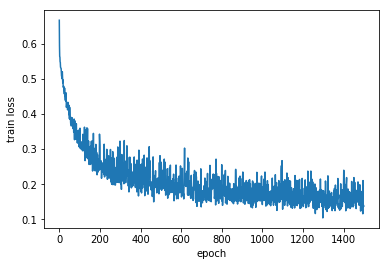

In [0]:
plt.plot(list(range(1500)), loss_history)

plt.xlabel('epoch')
plt.ylabel('train loss')

In [0]:
device1 = torch.device('cuda:1')

In [0]:
model = torch.load('segnet_clear.pt').to(device1)

In [0]:
dataset.is_train = False

In [0]:
sample = dataset[]

In [0]:
sample[0].shape

torch.Size([3, 2250, 4000])

In [0]:
# device_cpu = torch.device('cpu')

In [0]:
# model_test = torch.load('drive/''My Drive''/segnet_clear.pt').to(device_cpu)

In [0]:
model_test = torch.load('drive/''My Drive''/segnet_clear.pt').cuda()

In [0]:
dataset.is_train = False
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=valid_sampler, num_workers=10)

#model = model.to(device)

In [71]:
img, mask = next(iter(val_loader))

RuntimeError: ignored

In [0]:
img = img.view(3,img.shape[2],img.shape[3]).permute(1,2,0)
img = img.cpu().numpy()

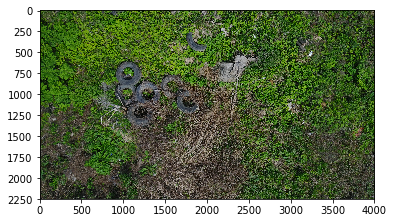

In [66]:
plt.imshow(img)

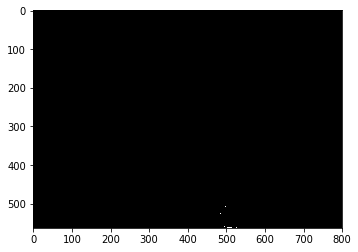

In [70]:
h = img.shape[0]
w = img.shape[1]

h_arr = np.linspace(0, h, num=5, dtype=int)
w_arr = np.linspace(0, w, num=6, dtype=int)

whole_img_pred = np.zeros(shape=(img.shape[0],img.shape[1]))

for current_h, next_h in zip(h_arr, h_arr[1:]):
  for current_w, next_w in zip(w_arr, w_arr[1:]):
    sub_img = img [current_h:next_h , current_w:next_w, :]
    
    sub_img = torch.Tensor(sub_img)
    prediction = model_test.forward(sub_img.contiguous().view(1, 3, sub_img.shape[0], sub_img.shape[1]).cuda()).cuda()
    preds_class = torch.max(prediction, dim=1)[1]
    plt.imshow(preds_class.squeeze().cpu().numpy(), cmap="gray")
    whole_img_pred [current_h:next_h , current_w:next_w] = preds_class[0,:,:].cpu().numpy()


# plt.imshow(sub_img)

In [0]:
# sub_img = torch.Tensor(sub_img)

# prediction = model_test.forward(sub_img.contiguous().view(1, 3, sub_img.shape[0], sub_img.shape[1]).cuda()).cuda()
# preds_class = torch.max(prediction, dim=1)[1]

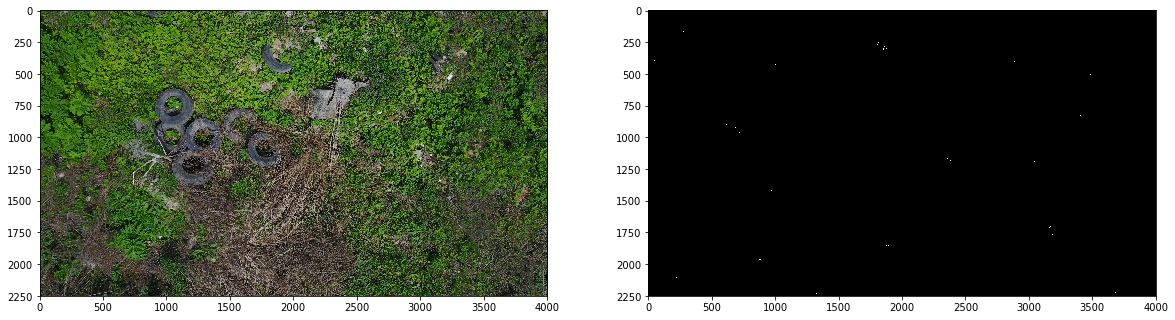

In [69]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(whole_img_pred, cmap="gray")

In [62]:
prediction = model_test.forward(img[0, :, :, :].view(1, 3, img.shape[2], img.shape[3]).to(device_cpu))
preds_class = torch.max(prediction, dim=1)[1]

NameError: ignored

In [0]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img[0, :, :].permute(1, 2, 0))

plt.subplot(1, 3, 2)
plt.imshow(mask[0, :, :], 'gray')

plt.subplot(1, 3, 3)
plt.imshow(preds_class.squeeze().cpu().numpy(), cmap="gray")

In [0]:
calc_iou(preds_class.squeeze().cpu().numpy(), mask[0, :, :].numpy())

0.48023976059177526

In [0]:
cv2.addWeighted(img, 0.7, overlay, 0.3, 0)